In [1]:
%load_ext autoreload
%autoreload 2

In [139]:
from collections import defaultdict
from pathlib import Path

import duckdb
import seaborn as sns
font_scale = 1
sns.set_theme(style='ticks', font_scale=font_scale, palette=sns.color_palette('Set2'),)
import sqlalchemy as sa
import seaborn as sns
import polars as pl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as tl

import conf.conf
import mftv.datasets
import mftv.main
import mftv.model
import mftv.plots

In [3]:
duckdb.sql("""
attach '../runs.sqlite';
use runs;
""")

In [7]:
session = conf.conf.Session()
session.begin()

In [23]:
dataset_start_rows = duckdb.sql("""
select
    *
from Dataset
join Gaussian on Dataset.id = Gaussian.id
""")
dataset_start_rows

┌────────────────┬───────┬───────┬────────┬───────┐
│ sa_inheritance │  id   │  dim  │  std   │  id   │
│    varchar     │ int64 │ int64 │ double │ int64 │
├────────────────┼───────┼───────┼────────┼───────┤
│ Gaussian       │     1 │     2 │    1.0 │     1 │
└────────────────┴───────┴───────┴────────┴───────┘

In [24]:
dataset_end_rows = duckdb.sql("""
select
    *
from Dataset
join Crescent on Dataset.id = Crescent.id
""")
dataset_end_rows

┌────────────────┬───────┬──────────────┬──────────────┬──────────────┬───────┐
│ sa_inheritance │  id   │ inner_center │ inner_radius │ outer_radius │  id   │
│    varchar     │ int64 │    double    │    double    │    double    │ int64 │
├────────────────┼───────┼──────────────┼──────────────┼──────────────┼───────┤
│ Crescent       │     2 │          0.5 │          0.6 │          1.0 │     2 │
└────────────────┴───────┴──────────────┴──────────────┴──────────────┴───────┘

In [25]:
model_rows = duckdb.sql("""
select
    *
from Model
join MeanFlow on Model.id = MeanFlow.id
""")
model_rows

┌────────────┬────────┬────────────────┬───────┬───────────────┬───────┐
│ batch_size │   lr   │ sa_inheritance │  id   │ tv_loss_coeff │  id   │
│   int64    │ double │    varchar     │ int64 │    double     │ int64 │
├────────────┼────────┼────────────────┼───────┼───────────────┼───────┤
│       1024 │  0.001 │ MeanFlow       │     1 │           0.0 │     1 │
└────────────┴────────┴────────────────┴───────┴───────────────┴───────┘

In [278]:
rows = duckdb.sql("""
select
    *
from Conf
join TrainingAndEvaluation on Conf.id = TrainingAndEvaluation.id
join model_rows on TrainingAndEvaluation.Model = model_rows.id
join dataset_start_rows on TrainingAndEvaluation.DatasetStart = dataset_start_rows.id
join dataset_end_rows on TrainingAndEvaluation.DatasetEnd = dataset_end_rows.id
where true
-- and alt_id in ('o9zukees')
and alt_id in ('2wyqij4m')
""")
rows.show(max_width=128)

┌──────────┬────────────┬──────────────────────┬───────┬───┬───────┬──────────────┬──────────────┬──────────────┬───────┐
│  alt_id  │  rng_seed  │    sa_inheritance    │  id   │ … │  id   │ inner_center │ inner_radius │ outer_radius │ id_1  │
│ varchar  │   int64    │       varchar        │ int64 │   │ int64 │    double    │    double    │    double    │ int64 │
├──────────┼────────────┼──────────────────────┼───────┼───┼───────┼──────────────┼──────────────┼──────────────┼───────┤
│ 2wyqij4m │ 2376999025 │ TrainingAndEvaluat…  │     2 │ … │     2 │          0.5 │          0.6 │          1.0 │     2 │
├──────────┴────────────┴──────────────────────┴───────┴───┴───────┴──────────────┴──────────────┴──────────────┴───────┤
│ 1 rows                                                                                           27 columns (9 shown) │
└───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



In [279]:
cfgs = session.query(conf.conf.TrainingAndEvaluation).where(conf.conf.Conf.alt_id.in_(rows.pl()['alt_id'].to_list())).all()
cfg = cfgs[0]

In [280]:
rng = np.random.default_rng(mftv.utils.RNG_RANDBITS['DATASET'][cfg.rng_seed])
(
    rng_dataset_start,
    rng_dataset_end,
    rng_mean_flow,
) = rng.spawn(3)

In [281]:
dataset_start = mftv.datasets.get_dataset(cfg.dataset_start, rng_dataset_start)
dataset_end = mftv.datasets.get_dataset(cfg.dataset_end, rng_dataset_end)

In [282]:
batch = next(iter(DataLoader(dataset_start, batch_size=cfg.model.batch_size))).to(cfg.device)
step_count = 100
times = torch.linspace(0., 1., step_count + 1, device=cfg.device).flip(0)
times.shape

torch.Size([101])

In [314]:
info = defaultdict(dict)
for cfg in cfgs:
    model = mftv.main.MeanFlow.load_from_checkpoint(
        cfg.run_dir/'last.ckpt',
        cfg=cfg, rng=rng_mean_flow,
        dataset_start=dataset_start, dataset_end=dataset_end,
        model=mftv.model.MeanFlowModel(input_dim=2, output_dim=2, dim=256, n_hidden=2),
    ).eval()
    info[cfg.alt_id]['model'] = model

In [315]:
with torch.no_grad():
    for v in info.values():
        x_start_time = batch
        for time_step, (start_time, end_time) in enumerate(times.unfold(0, 2, 1).view(step_count, 2, 1, 1).expand(step_count, 2, batch.shape[0], 1)):
            x_start_time = x_start_time - (end_time - start_time).abs() * v['model'](x_start_time, start_time, end_time)
            # x_start_time = x_start_time - (end_time - start_time).abs() * v['model'](x_start_time, end_time, start_time)
            # if time_step == step_count // 2:
            #     break
        v['sample'] = x_start_time

In [316]:
plot_data = rows.pl()
sample_data = []
target_data = next(iter(DataLoader(dataset_end, batch_size=cfg.model.batch_size)))
for alt_id in [
    'Start',
    'End',
    *plot_data['alt_id'],
]:
    if alt_id == 'Start':
        data = batch.cpu()
    elif alt_id == 'End':
        data = target_data
    else:
        data = info[alt_id]['sample'].cpu()
    data = (
        pl.DataFrame(data, schema=['sample_x', 'sample_y'])
        .with_columns(alt_id=pl.lit(alt_id))
    )
    sample_data.append(data)
sample_data = pl.concat(sample_data)
plot_data = plot_data.join(sample_data, on='alt_id', how='right')
plot_data

rng_seed,sa_inheritance,id,fit,predict,id_1,DatasetStart,DatasetEnd,Model,batch_size,lr,sa_inheritance_1,id_2,tv_loss_coeff,id_1_1,sa_inheritance_2,id_3,dim,std,id_1_2,sa_inheritance_3,id_4,inner_center,inner_radius,outer_radius,id_1_3,sample_x,sample_y,alt_id
i64,str,i64,i64,i64,i64,i64,i64,i64,i64,f64,str,i64,f64,i64,str,i64,i64,f64,i64,str,i64,f64,f64,f64,i64,f32,f32,str
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.116846,-0.063151,"""Start"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.451939,-0.82381,"""Start"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.901991,-0.585109,"""Start"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.493547,-0.346252,"""Start"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.591973,0.10406,"""Start"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2376999025,"""TrainingAndEvaluation""",2,1,0,2,3,2,1,1024,0.001,"""MeanFlow""",1,0.0,1,"""Gaussian""",3,2,0.5,3,"""Crescent""",2,0.5,0.6,1.0,2,0.297405,-0.665947,"""2wyqij4m"""
2376999025,"""TrainingAndEvaluation""",2,1,0,2,3,2,1,1024,0.001,"""MeanFlow""",1,0.0,1,"""Gaussian""",3,2,0.5,3,"""Crescent""",2,0.5,0.6,1.0,2,0.365782,-0.676767,"""2wyqij4m"""
2376999025,"""TrainingAndEvaluation""",2,1,0,2,3,2,1,1024,0.001,"""MeanFlow""",1,0.0,1,"""Gaussian""",3,2,0.5,3,"""Crescent""",2,0.5,0.6,1.0,2,-0.452049,-0.175387,"""2wyqij4m"""


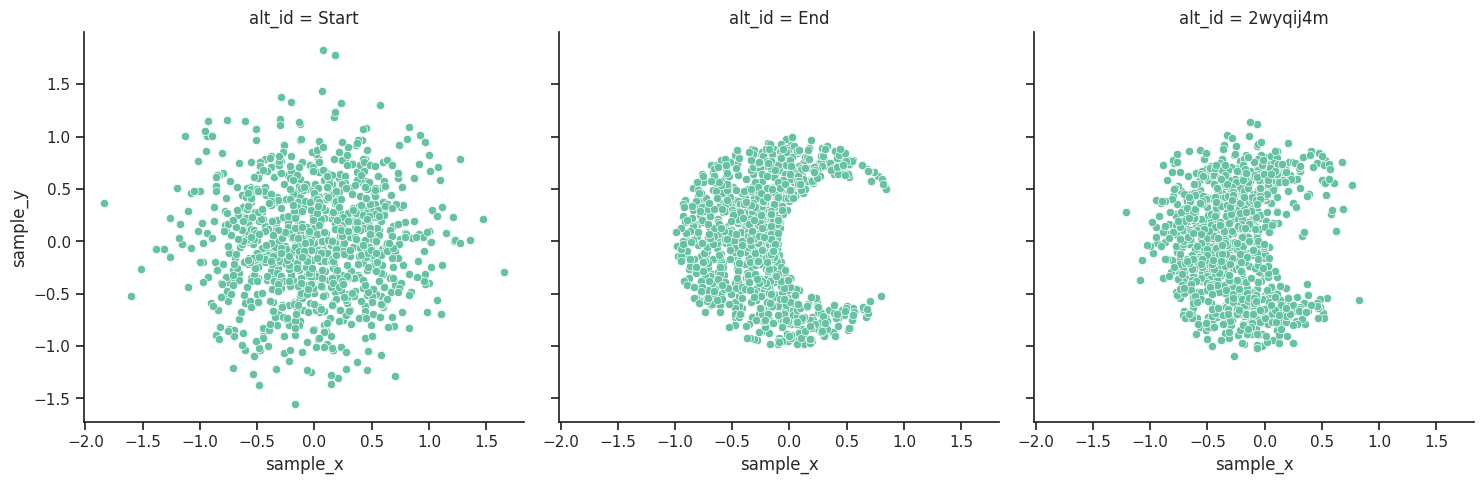

In [317]:
(
    sns.relplot(
        kind='scatter',
        data=plot_data,
        x='sample_x',
        y='sample_y',
        col='alt_id',
    )
)